# Adding custom behavioral events to an .set file

In this notebook, we 
*  read `raw` dual-EEG data
*  change channel names to HyPyP convention
*  read a textfile containing rows for behavioral event that are not MNE-formated 
*  format that dataframe to match the MNE convention for an `events` dataframe
*  make a `metadata` object from this newly made `events` dataframe
*  epoch our continuous `raw` data with the `metadata` 
*  *Sanity check*:
    * separate the newly made `epochs` object in two (on per subject)
    *  Compute the complex signal with HyPyP
    *  Compute Ccorr over th complex signal 

## Import

In [1]:
import mne

# from hypyp import prep
# from hypyp import utils
from hypyp import analyses

import hypyp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Create `raw`

In [2]:
root = "../../"
bdf_file = "SAMPLE.bdf"
target = root + bdf_file

In [3]:
raw = mne.io.read_raw_eeglab(input_fname=target)
raw.info

Reading /Users/zoubou/Documents/Scholar/UvA_M1_2/RP2_MBCS/RA-HyPyP/NorthWestern-Data/Social EEG Data for Preprocessing (Norton Lab)/codes-FP/latest code/../../W2W_2606_Movie/W2W_2606_movie_hpfilt.fdt


/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_15670/605695655.py:1: RuntimeWarning: Data file name in EEG.data (W2W_2606_movie_hpfilt_chlocs.fdt) is incorrect, the file name must have changed on disk, using the correct file name (W2W_2606_movie_hpfilt.fdt).
  raw = mne.io.read_raw_eeglab(input_fname=target)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 68 EEG
 custom_ref_applied: False
 dig: 68 items (68 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 68
 projs: []
 sfreq: 512.0 Hz
>

#### Change channel names to HyPyP convention

Hypyp expects dyadic data to be stored in a particular structure. Since we will use the participant's data in a merged object (i.e., containing all n channels for each participant), we must comply with HyPyP's channel naming convention to distinguish the two participants.

HyPyPs' convention is simple to follow. Participants' channel receives a ***suffix*** (`_S1` or `_S2`) to differentiate the first subject from the second.

Currently, our data has the ***prefix*** "2" added to the second participant. So we'll 
*  remove that prefix in the 2nd participant 
*  add to both participants the suffix associated with them

> ❗️ Do not try changing the channel's names yourself by just remplacing ther name directly in the `Raw` (see[ discours thread](https://mne.discourse.group/t/set-montage-info-channel-name-inconsistency-error/3881)).

In [5]:
# Observe channel names
# raw.info['ch_names]

# Store the ch names of each participant in their lists 
s1_chans_old = raw.ch_names[:32]
s2_chans_old = raw.ch_names[36:]
        # CAREFULL
        # Here we are not regarding 'vEOG', 'hEOG', 'A1', 'A2'

assert len(s1_chans_old) == len(s2_chans_old), "The channel lists have different sizes"

In [6]:
# Remove the suffix "2" in the 2nd participant's ch_names
# Add the suffixes for both participant's ch_names

s1_chans_new = []
s2_chans_new = []

for index in range(len(s1_chans_old)):
    s1_chans_new.append(s1_chans_old[index]     + '_S1')
    s2_chans_new.append(s2_chans_old[index][1:] + '_S2')

print('s1_chans: ', s1_chans_new)
print('\ns2_chans: ', s2_chans_new)

s1_chans:  ['Fp1_S1', 'AF3_S1', 'F7_S1', 'F3_S1', 'FC1_S1', 'FC5_S1', 'T7_S1', 'C3_S1', 'CP1_S1', 'CP5_S1', 'P7_S1', 'P3_S1', 'Pz_S1', 'PO3_S1', 'O1_S1', 'Oz_S1', 'O2_S1', 'PO4_S1', 'P4_S1', 'P8_S1', 'CP6_S1', 'CP2_S1', 'C4_S1', 'T8_S1', 'FC6_S1', 'FC2_S1', 'F4_S1', 'F8_S1', 'AF4_S1', 'Fp2_S1', 'Fz_S1', 'Cz_S1']

s2_chans:  ['Fp1_S2', 'AF3_S2', 'F7_S2', 'F3_S2', 'FC1_S2', 'FC5_S2', 'T7_S2', 'C3_S2', 'CP1_S2', 'CP5_S2', 'P7_S2', 'P3_S2', 'Pz_S2', 'PO3_S2', 'O1_S2', 'Oz_S2', 'O2_S2', 'PO4_S2', 'P4_S2', 'P8_S2', 'CP6_S2', 'CP2_S2', 'C4_S2', 'T8_S2', 'FC6_S2', 'FC2_S2', 'F4_S2', 'F8_S2', 'AF4_S2', 'Fp2_S2', 'Fz_S2', 'Cz_S2']


In [7]:
# We now creat a remplacement dictionnary
change_ch_names_dic_S1 = dict(zip(s1_chans_old, s1_chans_new))
change_ch_names_dic_S2 = dict(zip(s2_chans_old, s2_chans_new))

change_ch_names_dic_S1.update(change_ch_names_dic_S2)

In [9]:
raw.rename_channels(change_ch_names_dic_S1)

<RawEEGLAB | W2W_2606_movie_hpfilt.fdt, 68 x 157696 (308.0 s), ~93 kB, data not loaded>

#### Plot the `raw`

Using matplotlib as 2D backend.


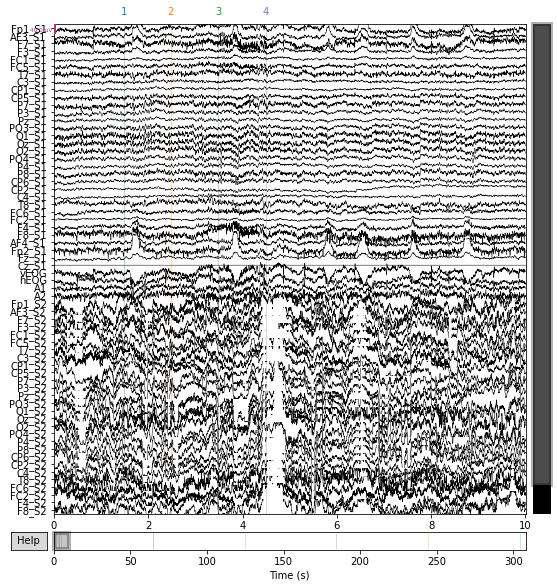

In [10]:
raw_plot = raw.plot(show=False, start=0, n_channels=len(change_ch_names_dic_S1))
plt.show()

## Create the `events` dataframe


#### Read behavioral events

This file contains, foe each rows, all behavioral events that occured during the experiment with their associated descriptors. Sidenote: the onset times are in sec.

In [11]:
event_csv = pd.read_csv(root + "MergedFileExample-FP.csv")

print("Event found in that file: %i" % event_csv.shape[0])
event_csv.head()

Event found in that file: 492


,item,bepoch,ecode,label,onset,diff,dura,b_flags,a_flags,enable,bin,(sec),(msec),(msec)_1,(binary),(binary)_1
0,1,0,1,NaN,0.6690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,NaN,0.6699,NaN,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2,NaN,1.6738,1003.9,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,3,NaN,2.6816,1007.8,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,4,NaN,3.6855,1003.9,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN


MNE represents the events timing as an integer sample number. Here we go from the time (sec) domain to the frequency domain (Hz)

In [12]:
# Convert seconds to samples
event_csv['onset'] *= raw.info['sfreq']

In [13]:
event_csv.head()

,item,bepoch,ecode,label,onset,diff,dura,b_flags,a_flags,enable,bin,(sec),(msec),(msec)_1,(binary),(binary)_1
0,1,0,1,NaN,342.5280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,NaN,342.9888,NaN,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2,NaN,856.9856,1003.9,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,3,NaN,1372.9792,1007.8,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,4,NaN,1886.9760,1003.9,0.0,0.0,0.0,1 [ ],NaN,NaN,NaN,NaN,NaN,NaN


See the event codes (called "ecode") we have and how many of each

In [14]:
print("there is %i different event code(s) in this file: " % len(event_csv['ecode'].unique()))
tmp = event_csv.groupby('ecode')['ecode']
tmp.count()

there is 15 different event code(s) in this file: 


ecode
1               2
2               1
3               1
4               1
5               1
6               1
7               1
8               1
9               1
10              1
11              1
20              1
2021200000    190
3221200000    256
3222200000     33
Name: ecode, dtype: int64

❗️ We have a small problem here ❗️ 

Because MNE doesn't work with events whose code are > INT32_MAX, we have to convert the `ecode` of our present data frame to shorten versions.

In [33]:
remplace_dict = {
    # 1:1, 2:2, 3:3, 4:4,
    3222200000:32222,
    2021200000:20212,
    # 5:5, 6:6,
    3221200000:32212, 
    # 7:7, 8:8, 9:9, 10:10, 11:11, 20:20
    }

# Change the event code is cool 
event_csv = event_csv.replace({"ecode": remplace_dict})

In [34]:
print("Here are the newly named 'ecode' : ", event_csv['ecode'].unique())

Here are the newly named 'ecode' :  [    1     2     3     4 32222 20212     5     6 32212     7     8     9
    10    11    20]


#### Select columns (and events) of interest 

In [43]:
# Add the needed 'dontuse' column to `event_csv` dataframe before formating it for MNE
# This column can also serve as a filter for bad events
event_csv['dontuse'] = 0

# Select column of interest
events_selected = event_csv.loc[:,['onset', 'dontuse','ecode']]

events_selected.head(10)

,onset,dontuse,ecode
0,342.5280,0,1
1,342.9888,0,1
2,856.9856,0,2
3,1372.9792,0,3
4,1886.9760,0,4
5,2262.2720,0,32222
6,2774.2720,0,32222
7,3286.2720,0,32222
8,3798.2720,0,32222
9,4310.2720,0,32222


### The [mne.epochs.make_metadata()](https://mne.tools/stable/generated/mne.epochs.make_metadata.html?highlight=make_metadata#mne.epochs.make_metadata) method

With mne.epochs.make_metadata(), we can define "events of interrest" (here, our ecode) and a time window around then (which doesn't have to be the same as the one used for epoching). The fucntion returns a callable object for mne.Epochs to create epochs from the 

In [44]:
# Convet the events df to np so MNE is happy
events_selected = events_selected.to_numpy()

In [45]:
# Define a dict with the event code and their "name"
event_id = {
    '1':1, '2':2, '3':3, '4':4,
    '32222':32222, 
    '20212':20212,
    '5':5, '6':6,
    '32212':32212,
    '7':7, '8':8, '9':9, '10':10, '11':11, '20':20
    }

In [46]:
meta_tmin, meta_tmax = 0.0, 1.0 # In seconds

metadata, events, event_id = mne.epochs.make_metadata(
    
    events=events_selected,
    event_id=event_id,
    tmin= meta_tmin, tmax= meta_tmax,
    
    # row_events=['1', '20212', '7', '8'], # select only event of choices
    row_events=['20212'], # select only event of choices
    
    sfreq=raw.info['sfreq']
    )

events = events.astype(int)

metadata.head()

,event_name,1,2,3,4,32222,20212,5,6,32212,7,8,9,10,11,20
38,20212,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,20212,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,20212,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,20212,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,20212,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


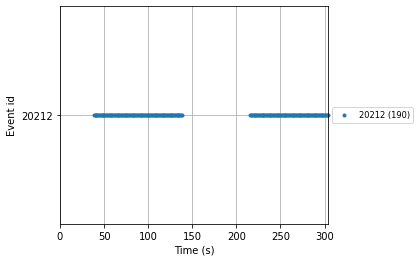

In [47]:
event_plot = mne.viz.plot_events(
    events, raw.info['sfreq'], 
    event_id=event_id,
    show=False)
plt.show()

### Create the Epoch object (both subject merged)

The following cell should be fixed shortly (See [github issue](https://github.com/ppsp-team/HyPyP/pull/76)).

In [48]:
# raw_S1, raw_S2 = hypyp.utils.split(raw)

In [49]:
epochs_tmin, epochs_tmax = 0.0, 1.0  # epochs range in sec
reject = {'eeg': 250e-6}  # exclude epochs with strong artifacts


epochs_S1 = mne.Epochs(
    
    raw=raw, 
    events=events,
    event_id=event_id,

    tmin=epochs_tmin, tmax=epochs_tmax,
    
    metadata=metadata,
    
    event_repeated= 'merge',
    baseline=None,

    # reject=reject, 
    preload=True)

epochs_S2 = epochs_S1.copy()

Adding metadata with 16 columns
Replacing existing metadata with 16 columns
190 matching events found
No baseline correction applied
0 projection items activated
Loading data for 190 events and 513 original time points ...
0 bad epochs dropped


Drop channels in epochs__S1 that belongs to S2 and *vice versa*


In [50]:
epochs_S1.drop_channels(s2_chans_new)
epochs_S2.drop_channels(s1_chans_new)

Number of events,190
Events,20212: 190
Time range,0.000 – 1.000 sec
Baseline,off


In [51]:
data_inter = np.array([epochs_S1, epochs_S2])
results_intra = []

In [ ]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

In [ ]:
complex_signal = hypyp.analyses.compute_freq_bands(data_inter, epochs_S1.info['sfreq'],
                                             freq_bands)

In [ ]:
complex_signal.shape

In [ ]:
results = hypyp.analyses.compute_sync(complex_signal, 'ccorr', epochs_average=True)

In [ ]:
results.shape

### Questions left to answer:

* What bound are the most sensible to use for epoching (e.g., 0 to 1sec or -0.2 to 0.8)?
* do we need to operate baseline correction when epoching with the metadata method?
* What montage do we use (note: hypyp.utils.split does a great a that but has a bug rendering it unstable)
* How to deal with these electrodes: 'vEOG', 'hEOG', 'A1', 'A2'? should I duplicate them so each subject can have them? They could also be removed if unnecessary.


In [ ]:
# montage_fname = 'standard_1020'

# epochs_S1.set_montage(montage_fname)
# epochs_S2.set_montage(montage_fname)

## To look into 

- How to [better index epochs](https://jasmainak.github.io/mne-workshop-brown/raw_to_evoked/epochs.html) (see session "Indexing Epochs").